In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math

In [3]:
def plotUpdate(first, second, third, title, firstLabel, secondLabel, thirdLabel, ylabel, ylim, loc = False):
    firstLine, = plt.plot([i for i in range(0,len(first))], first)
    secontLine, = plt.plot([i for i in range(0,len(second))], second)
    thirdLine, = plt.plot([i for i in range(0,len(third))], third)
    plt.xlabel('t')
    plt.ylim(ylim)
    plt.ylabel(ylabel)
    plt.title(title)
    if loc:
        plt.legend([firstLine, secontLine, thirdLine], [firstLabel, secondLabel, thirdLabel], loc = (0.624,0))
    else:
        plt.legend([firstLine, secontLine, thirdLine], [firstLabel, secondLabel, thirdLabel])
    plt.grid(True)

In [4]:
import os
import struct
from array import array


class MNIST(object):
    def __init__(self, path='../HW1/dataset'):
        self.path = path

        self.test_img_fname = 't10k-images-idx3-ubyte'
        self.test_lbl_fname = 't10k-labels-idx1-ubyte'

        self.train_img_fname = 'train-images-idx3-ubyte'
        self.train_lbl_fname = 'train-labels-idx1-ubyte'

        self.test_images = []
        self.test_labels = []

        self.train_images = []
        self.train_labels = []

    def load_testing(self):
        ims, labels = self.load(os.path.join(self.path, self.test_img_fname),
                                os.path.join(self.path, self.test_lbl_fname))
        ims = map(lambda img: img, ims)
        self.test_images = ims
        self.test_labels = labels
        ims = map(lambda img: [255]+img, ims)
        ims = np.array(ims)*1.0/255
        mean = ims.sum(axis=1)[:,None]/785
        ims -= mean
        return ims, np.array(labels)

    def load_training(self):
        ims, labels = self.load(os.path.join(self.path, self.train_img_fname),
                                os.path.join(self.path, self.train_lbl_fname))
        ims = map(lambda img: img, ims)
        self.train_images = ims
        self.train_labels = labels
        ims = map(lambda img: [255]+img, ims)
        ims = np.array(ims)*1.0/255
        mean = ims.sum(axis=1)[:,None]/785
        ims -= mean
        return ims, np.array(labels)

    @classmethod
    def load(cls, path_img, path_lbl):
        with open(path_lbl, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049,'
                                 'got {}'.format(magic))

            labels = array("B", file.read())

        with open(path_img, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051,'
                                 'got {}'.format(magic))

            image_data = array("B", file.read())

        images = []
        for i in range(size):
            images.append([0] * rows * cols)

        for i in range(size):
            images[i][:] = image_data[i * rows * cols:(i + 1) * rows * cols]

        return images, labels
  

    def showImage(self, imageArray, title = "", xlabel = ""):
        imageArray = imageArray.reshape((28,28))
        fig = plt.figure()
        plotwindow = fig.add_subplot(111)
        plt.xlabel(title)
        
        plt.imshow(imageArray, cmap='gray')
        plt.show()

In [5]:
mnist = MNIST()
trainingImgs, trainingLabels = mnist.load_training()
testImgs, testLabels = mnist.load_testing()

In [18]:
class MNISTClassification():
    def __init__(self):
        self.stepSize = 1e-3
        self.maxIter = 0
        self.w_jk = None
        self.w_ij = None
        self.numHidden = 60
        self.numClass = 10
        self.epsilon = 1e-2 # for check gradient
        
        self.trainAccuracyPath = []
        self.validationAccuracyPath = []
        self.testAccuracyPath = []
        self.maxValidationAccuracy = -1
        self.w_ijPath = []
        self.w_jkPath = []
        self.preHiddenGradient = 0
        self.preOutputGradient = 0
        self.optimize = False
        
    def fit(self, trainingImgs, trainingLabels, testImgs, testLabels, miniBatch,\
            stepSize = None, T = 1000, checkGradient = False, numHidden = 60, maxIter = 1000, optimize = False):
        self.numHidden = numHidden
        np.random.seed(0)
        w_ij = np.random.normal(0, 0.1, size = (len(trainingImgs[0]), self.numHidden))
        w_jk = np.random.normal(0, 0.1, size = (self.numHidden + 1, self.numClass))
        if optimize:
            w_ij = np.random.normal(0, 1/math.sqrt(len(trainingImgs[0])), size = (len(trainingImgs[0]), self.numHidden))
            w_jk = np.random.normal(0, 1/math.sqrt(self.numHidden), size = (self.numHidden + 1, self.numClass))
        if stepSize:
            self.stepSize = stepSize
        self.optimize = optimize
        
        self.maxIter = maxIter
        
        self.train(trainingImgs, trainingLabels, testImgs, testLabels, w_ij, w_jk, miniBatch,\
                   self.stepSize, T, checkGradient, numHidden)
        
    def predictHidden(self, w_ij, X):
        '''
        X: batch * 784
        w_ij: 784 * j
        return: Z batch * j
        '''
        if self.optimize:
            return 1.7159*np.tanh(2./3.*np.dot(X, w_ij)) # part4
        return 1/(1+np.exp(-np.dot(X, w_ij))) #part3
    
    def predictOutput(self, w_jk, Z):
        '''
        Z: batch * j
        w_jk: j * 10(= k)
        return: prob y batch * 10(=k)
        '''
        expProb = np.exp(np.dot(Z, w_jk))
        probability = expProb/expProb.sum(axis=1)[:,None] # batch * k
        return probability
    
    def loss(self, X, y, t, w_ij, w_jk):
        '''
        X: batch * 784
        y: batch
        w_ij: 784 * j
        w_jk: j * 10(=k)
        '''
        loss = 0
        Z = self.predictHidden(w_ij, X)
        probability = self.predictOutput(w_jk, Z)
        return -np.sum(t*np.log(probability))
    
    def train(self, X, y, testImgs, testLabels, w_ij, w_jk, batch, stepSize, T, checkGradient, numHidden):
        numIter = 0
        start = 0
        stepSize_ini = stepSize
        eta = 0.9 #1/(1+ np.exp(-numIter/250)) # momentum parameter
        # Split validation and training
        partial = int(math.ceil(len(X)/6.*5.))
        validationImgs = X[partial:]
        validationLabels = y[partial:]
        X = X[:partial]
        y = y[:partial]
        
        while numIter < self.maxIter:
            stepSize = stepSize_ini * 1./(1 + numIter*1./T) # learning rate
            end = min(start + batch, len(X))
                
            X_batch = X[start: end]
            y_batch = y[start: end]
            
            Z_batch = self.predictHidden(w_ij, X_batch) # batch * j
            Z_batch = np.hstack([np.ones((len(Z_batch),1)), Z_batch]) #  batch * (j+1)(add bias to Z)
            probability = self.predictOutput(w_jk, Z_batch) # batch * 10  
            
            t_batch = np.zeros((len(y_batch), self.numClass)) # batch * 10
            for n in range(0, len(y_batch)):
                t_batch[n, y[n]] = 1
            
            delta_k = t_batch - probability
            
            if self.optimize: # tanh softmax for hiddenlayer
                delta_j = (2./3*(1.7159 - (Z_batch**2)/1.7159)* np.dot(delta_k, w_jk.T))[:,1:]# batch*j #part4
            else:
                delta_j = (Z_batch*(1-Z_batch)*np.dot(delta_k, w_jk.T))[:, 1:] # batch * j #part3 delete
            
            if checkGradient:
                print "Check gradient diff:", self.checkGradient(-delta_j, -delta_k, t_batch, X_batch, y_batch, Z_batch, w_ij, w_jk)
                break
                
            w_ij_update = stepSize / len(X_batch) * np.dot(X_batch.T, delta_j)
            w_jk_update = stepSize / len(X_batch) * np.dot(Z_batch.T, delta_k) 
            
            if self.optimize: # momentum
                w_ij_update += eta*self.preHiddenGradient
                w_jk_update += eta*self.preOutputGradient
                self.preHiddenGradient = w_ij_update
                self.preOutputGradient = w_jk_update
               
            w_ij += w_ij_update
            w_jk += w_jk_update
            start = end
            
            if start >= len(X):
                start = 0
                numIter += 1
                stepSize = stepSize_ini * 1./(1 + numIter*1./T)
                self.trainAccuracyPath.append(self.test(X, y, w_ij, w_jk))
                validationAccuracy = self.test(validationImgs, validationLabels, w_ij, w_jk)
                self.validationAccuracyPath.append(validationAccuracy)
                
                # record the weights where the validation accuracy is maximum
                if validationAccuracy > self.maxValidationAccuracy:
                    self.w_ij = w_ij
                    self.w_jk = w_jk
                    self.maxValidationAccuracy = validationAccuracy
                self.testAccuracyPath.append(self.test(trainingImgs, trainingLabels, w_ij, w_jk))
                
                # early stopping
                if len(self.validationAccuracyPath) > 100 and \
                self.validationAccuracyPath[-4] > self.validationAccuracyPath[-3] > \
                self.validationAccuracyPath[-2] > self.validationAccuracyPath[-1]:
                    print "Converge at ", numIter, "final correction rate is", self.testAccuracyPath[-3]
#                     break
                    
                if numIter % 10 == 0:
                    print "Number iteration:", numIter,", correction rate:", self.testAccuracyPath[-1]

    def checkGradient(self, hiddenLayerGradient, OutputLayerGradient, t, X, y, Z, w_ij, w_jk):
        # Check w_ij gradient
        hiddenLayerGradient = np.dot(X.T, hiddenLayerGradient)/len(X) # i*j
        gradientDiffWij = np.zeros(hiddenLayerGradient.shape) # i*j
        epsilonMatrix = np.zeros(w_ij.shape)
        for i in range(0, len(w_ij)):
            for j in range(0, len(w_ij[0])):
                epsilonMatrix[i][j] += self.epsilon
                Z1 = self.predictHidden(w_ij + epsilonMatrix, X)
                probability1 = self.predictOutput(w_jk, np.hstack([np.ones((len(Z1),1)), Z1]))
                Z2 = self.predictHidden(w_ij - epsilonMatrix, X)
                probability2 = self.predictOutput(w_jk, np.hstack([np.ones((len(Z2),1)), Z2]))
                E1 = -np.sum(t*np.log(probability1))
                E2 = -np.sum(t*np.log(probability2))
                gradientDiffWij[i][j] = abs(hiddenLayerGradient[i][j] - (E1-E2)/2/self.epsilon)
                epsilonMatrix[i][j] -= self.epsilon
        # check w_jk gradient
        epsilonMatrix = np.zeros(w_jk.shape)
        OutputLayerGradient = np.dot(Z.T, OutputLayerGradient)/len(Z) # j*k
        gradientDiffWjk = np.zeros(OutputLayerGradient.shape) # j*k
        for j in range(0, len(w_jk)):
            for k in range(0, len(w_jk[0])):
                epsilonMatrix[j][k] += self.epsilon
                probability1 = self.predictOutput(w_jk + epsilonMatrix, Z)
                probability2 = self.predictOutput(w_jk - epsilonMatrix, Z)
                E1 = -np.sum(t*np.log(probability1))
                E2 = -np.sum(t*np.log(probability2))
                gradientDiffWjk[j][k] = abs(OutputLayerGradient[j][k] - (E1-E2)/2/self.epsilon)
                epsilonMatrix[j][k] -= self.epsilon

        return np.mean(gradientDiffWij), np.mean(gradientDiffWjk), np.max(gradientDiffWij), np.max(gradientDiffWjk)
    
    def test(self, X, y, w_ij, w_jk):
        Z = self.predictHidden(w_ij, X)
        probability = self.predictOutput(w_jk, np.hstack([np.ones((len(Z),1)), Z]))
        predict = np.argmax(probability, axis=1) # batch
        match = filter(lambda x: x[0] == x[1], zip(predict, y))
        return len(match)*1.0/len(y)

In [73]:
mn = MNISTClassification()
mn.fit(trainingImgs, trainingLabels, testImgs, testLabels, 60000, 1, T = 700, numHidden = 120, maxIter = 1000, optimize = True)

Number iteration: 10 , correction rate: 0.633933333333
Number iteration: 20 , correction rate: 0.862633333333
Number iteration: 30 , correction rate: 0.9024
Number iteration: 40 , correction rate: 0.936616666667
Number iteration: 50 , correction rate: 0.951666666667
Number iteration: 60 , correction rate: 0.959616666667
Number iteration: 70 , correction rate: 0.965383333333
Number iteration: 80 , correction rate: 0.969933333333
Number iteration: 90 , correction rate: 0.973116666667
Number iteration: 100 , correction rate: 0.97515
Number iteration: 110 , correction rate: 0.976966666667
Number iteration: 120 , correction rate: 0.978983333333
Number iteration: 130 , correction rate: 0.980466666667
Number iteration: 140 , correction rate: 0.98175
Number iteration: 150 , correction rate: 0.982983333333
Number iteration: 160 , correction rate: 0.984183333333
Number iteration: 170 , correction rate: 0.985366666667
Number iteration: 180 , correction rate: 0.98635
Number iteration: 190 , correc

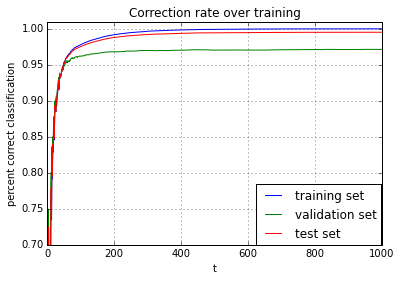

In [74]:
plotUpdate(mn.trainAccuracyPath, mn.validationAccuracyPath, mn.testAccuracyPath, 'Correction rate over training',
           'training set', 'validation set','test set', "percent correct classification",[0.7,1.01], True)
plt.savefig('part5_whole_120unit_1_700.png', bbox_inches='tight') #Number iteration: 1000 , correction rate: 0.928116666667

In [75]:
for i in [100,200,300,400,500,600,700,800,900,1000]:
    print i,"&",mn.trainAccuracyPath[i-1],"&", mn.validationAccuracyPath[i-1],"&", mn.testAccuracyPath[i-1]

100 & 0.97782 & 0.9618 & 0.97515
200 & 0.99186 & 0.9682 & 0.987916666667
300 & 0.99654 & 0.9698 & 0.992083333333
400 & 0.99836 & 0.9703 & 0.993683333333
500 & 0.99924 & 0.9704 & 0.994433333333
600 & 0.99958 & 0.9703 & 0.9947
700 & 0.99982 & 0.971 & 0.995016666667
800 & 0.99992 & 0.9711 & 0.995116666667
900 & 0.99996 & 0.9711 & 0.99515
1000 & 0.99998 & 0.9714 & 0.995216666667


In [9]:
checkGradient = MNISTClassification()
checkGradient.fit(trainingImgs[:1], trainingLabels[:1], testImgs, testLabels, 1, 1, checkGradient = True)

Check gradient diff: (1.1916369640615067e-08, 1.5967735680372368e-07, 3.3150166168366413e-07, 1.6028107083787546e-06)


In [7]:
randomData = zip(trainingImgs, trainingLabels)
random.seed(2)
random.shuffle(randomData)
randomTrainImgs, randomTrainLabels = np.array(map(lambda x:x[0], randomData)), np.array(map(lambda x:x[1], randomData))

In [19]:
optimalMN = MNISTClassification()
optimalMN.fit(randomTrainImgs, randomTrainLabels, testImgs, testLabels, 1000, 0.005, T = 20, numHidden = 60, optimize = True )

In [20]:
plotUpdate(optimalMN.trainAccuracyPath, optimalMN.validationAccuracyPath, optimalMN.testAccuracyPath, 'Correction rate over training',
           'training set', 'validation set','test set', "percent correct classification",[0,0.9], True)
# plt.savefig('part4_10000_02_50.png', bbox_inches='tight') #Number iteration: 1000 , correction rate: 0.928116666667